# Subreddit NLP Classification - Modelling and Evaluation

With our datasets fully cleaned, explored, and processed we can begin training our classifer models to distinguish between the r/xbox and r/playstation subreddits and identify the topics of discussion between them.

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

To begin with, we will bring in our finished datasets and convert them into a more compact form for faster model training.

In [289]:
# Importing cleaned and vectorized datasets
X_train_tfidf = pd.read_csv('../datasets/X_train_tfidf.csv', index_col=0)
X_test_tfidf = pd.read_csv('../datasets/X_test_tfidf.csv', index_col=0)
y_train = pd.read_csv('../datasets/y_train.csv', index_col=0).subreddit
y_test = pd.read_csv('../datasets/y_test.csv', index_col=0).subreddit

In [290]:
# Converting feature datasets into sparse matrices for time efficiency
X_train_sparse = X_train_tfidf.astype(pd.SparseDtype("float64",0)).sparse.to_coo()
X_test_sparse = X_test_tfidf.astype(pd.SparseDtype("float64",0)).sparse.to_coo()

## Initial Modelling

### Establishing the Baseline

In order to evaluate the effectiveness of the models we will be training, it is important to have a baseline against which to compare. For classifier models like the one we wish to build, the baseline is to simply guess the most common class in our dataset every time.

The following cell displays the proportion of each subreddit in our dataset for the purposes of determining the baseline.

In [291]:
# Checking the majority class
y_test.value_counts(normalize=True)

playstation    0.514484
xbox           0.485516
Name: subreddit, dtype: float64

Since r/playstation is the most prevalent subreddit in our dataset, with 51.4% of the posts, the baseline model would be to assume that all posts are from r/playstation. As such, the accuracy that our models must beat is 0.514.

### Selecting Models to Train

Before we move directly into modelling, it is worth considering what we want from our model. Not all classifier models are equally capable of performing any task and many of them sacrifice interpretability for higher accuracy. Since our intention is to use our trained classifer to identify words and topics that can be used to distinguish between our two subreddits of interest, it is vital to ensure that our selected models can tell us which words were most important when distinguishing between posts.

Since interpretability is required for us to be able to address our goals, we cannot utilize black-box models like Neural Networks or Nearest Neighbors that have no intuitive notion of feature importance. Within these constraints, three promising models for our purposes are Logistic Regression, Random Forest, and AdaBoost.

### Logistic Regression

Logistic Regression is a model based on Linear Regression that assigns a weight to each word in the dataset based on the degree to which the classifier can distinguish between its target groups using it. Of all our three models, Logistic Regression has the highest interpretability since it is capable of quantifying not only the importance of each word for distinguishing between subreddits but also which of the subreddits that word happens to be more closely associated with.

However, this has significantly less predictive ability than the others. As it is based on Linear Regression, it inherits many of Linear Regression's limitations and assumption, such as relying on normally distributed data. If this model's accuracy ends up being significantly lower than the others, than it will not be the best choice for our inferences despite its high interpretability.

The following cell trains and scores an optimized Logistic Regression model by training several models with different parameters and selecting the one with the best performance.

In [294]:
# Defining logistic regression parameters to sweep over
logreg_params = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1,10,100]
}
# GridSearching logistic regression classifiers
logreg_grid = GridSearchCV(LogisticRegression(solver='liblinear'), logreg_params, n_jobs=-1)
logreg_grid.fit(X_train_sparse, y_train)
# Printing out train and test accuracy scores
print(f'Training accuracy: {logreg_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {logreg_grid.score(X_test_sparse, y_test)}')

Training accuracy: 0.8567629976908544
Testing accuracy:0.7829554995801847


Here we can see that our Logistic Regression has achieved a testing accuracy of approximately 0.8. In addition, the fact that the train and test scores are so close to each other indicates that the model is not greatly overfitting and simply lacks either enough complexity or data to achieve a higher accuracy.

We can get a better understanding of the _way_ in which our model's inaccuracies manifest by looking at our model's confusion matrix.

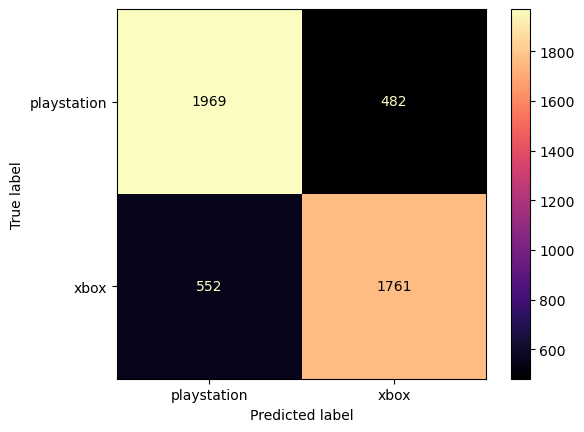

In [295]:
# Printing out confusion matrix for logistic regressor
ConfusionMatrixDisplay.from_estimator(logreg_grid, X_test_sparse, y_test, cmap='magma');

From this confusion matrix, we can see that our model is not strongly biased towards either subreddit and appears to err mostly at random.

Given that our training data contains nearly as many word columns as posts, this model is likley being held back by insufficient data. Despite this, the model's performance is quite good when we consider that self-referential terms were preemptively stripped from our dataset. Should no models outperform the logistic regressor by a significant amount, then we would be wise to use Logistic Regression as our subreddit model due to its high interpretability.

### Random Forest

Random Forest is a model based on the large scale use of decision trees. Decision trees are flexible and powerful models that seek to make incremental splits on a dataset's features in order to assign classifications based on where a given entry falls at the end of the tree. Decision trees are well known for grossly overfitting to their datasets in a way that can greatly reduce their effectiveness. Random Forest mitigates this issue by training a large number of trees on smaller amounts of data and making predictions based on a consensus or average result across all decision trees.

Compared to Logistic Regression, Random Forest has less interpretability since it _can_ provide a quantifiable importance for each word (through metrics such as Gini Impurity or Entropy) but _cannot_ indicate which of the two subreddits a word is more closely associated with. Despite this, Random Forest's ability to capture complex patterns in a dataset gives it the potential to achieve a higher accuracy than Logistic Regression. If its accuracy ends up being significantly higher, we would be wise to select it over the more interpretable Logistic Regression for the sake of being accurate in our inferences.

The following cell trains and scores an optimized Random Forest classifier by training several models with different parameters and selecting the one with the best performance.

In [296]:
# Defining random forest parameters to sweep over
rfc_params = {
    'n_estimators':[100,1000],
    'max_depth':[10,100,1000],
    'ccp_alpha':[0, 0.01, 0.1]
}
# GridSearching random forest classifiers
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, n_jobs=-1)
rfc_grid.fit(X_train_sparse, y_train)
# Displaying train and test scores
print(f'Training accuracy: {rfc_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {rfc_grid.score(X_test_sparse, y_test)}')

Training accuracy: 0.9995801553425233
Testing accuracy:0.7819059613769941


Here we can see that our optimized Random Forest model very slightly underperforms our Logistic Regression in testing accuracy while being extremely overfit to the training dataset.

We can once again look at the confusion matrix for our model to see how its errors are distributed.

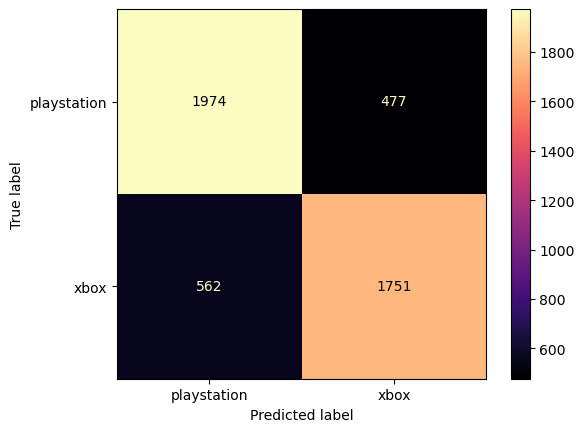

In [330]:
# Showing confusion matrix for random forest
ConfusionMatrixDisplay.from_estimator(rfc_grid, X_test_sparse, y_test, cmap='magma');

As with the logistic regressor, our Random Forest model appears to err mostly at random with a slight bias towards predicting playstation due to our dataset containing slightly more playstation posts than xbox posts.

Compared to our Logistic Regressor, our Random Forest has nearly identical testing performance and a similar distribution of errors. However, it also shows signs of very extreme overfitting that suggest that the model is attempting to memorize the original dataset rather than learn the underlying trends. This, combined with Random Forest being less interpretable, makes this model a worse choice than Logistic Regression for our subreddit modelling needs.

### AdaBoost

Like Random Forest, AdaBoost is a model that makes use of a large number of decision trees. Rather than training multiple full-size decision trees on portions of data, AdaBoost opts to train multiple shallow decision trees on the entire dataset. Every time a shallow tree is trained in AdaBoost, the model checks which data points the new tree failed to correctly predict and assigns extra importance to those entries when training the next shallow tree. Through the use of shallow trees, AdaBoost avoids the issue of overfitting that plagues tree-based models while retaining predictive power through its training method. And as a tree-based model, AdaBoost retains the ability to provide feature importance metrics in the same way as Random Forest.

However, the same training method that allows AdaBoost to perform so well also introduces a unique set of flaws that limit its utility. Since the model relies so heavily on changing the importance of data points in its training data, AdaBoost is particularly sensitive to the quality and size of its dataset. If not given sufficient data or if given noisy data, AdaBoost can fail to produce adequate results.

The following cell trains and scores an optimized AdaBoost classifier by training several models with different parameters and selecting the one with the best performance.

In [329]:
# Defining AdaBoost parameters to sweep over
abc_params = {
    'n_estimators':[100,200,500],
    'learning_rate':[0.5,1,1.5]
}
# GridSearching AdaBoost classifiers
abc_grid = GridSearchCV(AdaBoostClassifier(), abc_params, n_jobs=-1)
abc_grid.fit(X_train_sparse, y_train)
# Displaying train and test scores
print(f'Training accuracy: {abc_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {abc_grid.score(X_test_sparse, y_test)}')

Training accuracy: 0.8314323700230914
Testing accuracy: 0.7632241813602015


From the scores above, we can see that the AdaBoost model showed worse testing accuracy than either the Logistic Regression or Random Forest models. From its low training score, we can infer that our model has underperformed due to a lack of predictive ability rather than due to overfitting. This is likely due to our dataset not meeting the requirements for AdaBoost. Since AdaBoost is sensitive to low quality or small datasets, it was likely unable to properly fit to our extremely small and sparse dataset.

Once more, we can look at the confusion matrix for our model to better understand the distribution of errors within it.

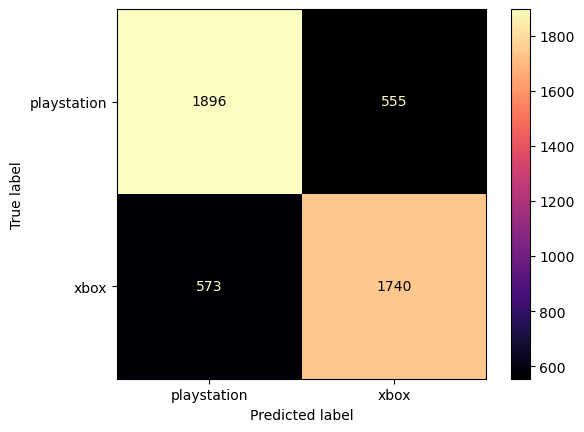

In [360]:
# Showing confusion matrix for AdaBoost
ConfusionMatrixDisplay.from_estimator(abc_grid, X_test_sparse, y_test, cmap='magma');

Here we can see that the AdaBoost model is not significantly biased towards either subreddit and has a nearly identical number of misclassifed r/playstation and r/xbox posts.

Sadly, the AdaBoost model performed noticeably worse than both the Logistic Regression and Random Forest models with lower testing _and_ training accuracies. Since this model does not have higher interpretability than the others and does not possess any other feature that would give us reason to use it, we can conclude that it would be a worse choice than Logistic Regression for our subreddit modelling purposes.

After training and evaluating all three model candidates, we can now select Logistic Regression as our model of choice for identifying the differences between the two subreddits due to its high test accuracy and interpretability. With our model thus selected, we can move on to interpreting its findings.

## Extracting Interpretations

Within the trained Logistic Regression model, each word in our original dataset is given a weight that quantifies the degree to which the model can use that word's presence to determine which subreddit a post came from. For each of these weights, their magnitude determines the word's subreddit-distinguishing ability while their sign determines the subreddit they are more closely associated with.

In order to visualize the most significant of these weights, their magnitudes can used to arrange them in descending order of importance. Since high-magnitude weights can be used to distinguish between subreddits, we can inspect them to determine the topics of conversation that could be found in one subreddit but not the other. If any of the highest-weighted words are not about the playstation or xbox consoles themselves, then we would be able to use them to infer the deeper differences between the iscussions of our two Reddit communities.

The following two cells extract feature weights from our logistic regressor and plot the largest of them for evaluation.

In [381]:
# Extracting the feature weights from the logistic regression model
interpretation_df = pd.DataFrame(logreg_grid.best_estimator_.coef_.transpose(),
                                 index=X_train_tfidf.columns)
interpretation_df = interpretation_df.rename(mapper={0:'logreg_feature_weight'}, axis=1)
# Adding a column containing the absolute value of the feature weights
# to allow for the weights to be sorted by magnitude
interpretation_df['logreg_feature_weight_abs'] = interpretation_df.logreg_feature_weight.apply(np.abs)

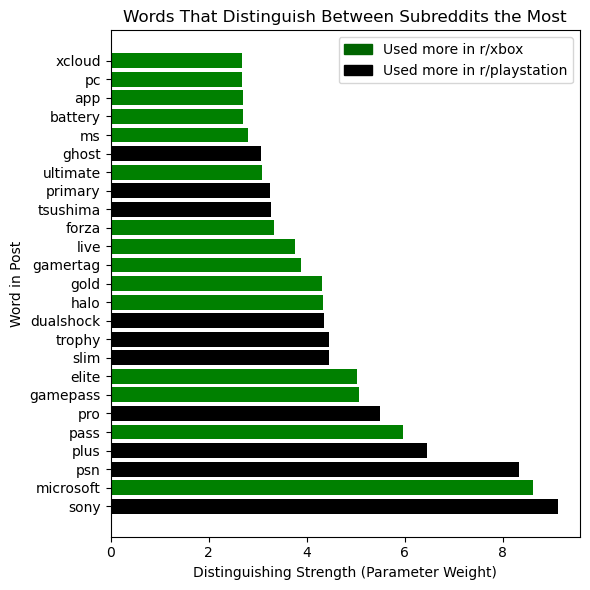

In [379]:
# Plotting the highest feature weights of the logistic regression model
important_features_df = interpretation_df.sort_values('logreg_feature_weight_abs', ascending=False).head(25);
plt.figure(figsize=(6,6));
colors = ["green" if weight > 0 else "black" for weight in important_features_df.logreg_feature_weight];
plt.barh(y = important_features_df.index, width = important_features_df.logreg_feature_weight_abs, color=colors);
plt.xlabel("Distinguishing Strength (Parameter Weight)");
plt.ylabel('Word in Post');
#plt.title('Words That Most Distinguish Between Posts From Each Subreddit');
plt.title('Words That Distinguish Between Subreddits the Most');
plt.legend(handles=[mpatches.Patch(color='darkgreen', label='Used more in r/xbox'),
                    mpatches.Patch(color='black', label='Used more in r/playstation')]);
plt.tight_layout();
plt.savefig('../images/distinguishing_features.png');

In this plot of feature weights, we can see that nearly all the words the model deems most important when distinguishing between subreddits fall within one of three general categories.

Words such as 'psn', 'plus', 'live', and 'gamepass' all reference online services that can be found on the consoles that our two subreddits are names after. 'psn' and 'live' refer to the Playstation Network and Xbox Live respectively, which are the networks that each console uses to facilitate online interactions such as player messaging and online purchases. Similarly, 'plus' and 'gamepass' refer to Playstation Plus and Xbox Game Pass, which are online subscription services that each consoles offer that allow users to access a rotating library of games. The majority of words deemed important by the model reference online services in some way.

Words such as 'dualshock' and 'battery' reference peripheral devices such as controllers that are used by each subreddit's console. 'dualshock' is associated with r/playstation because Playstation consoles all use a series of controllers known as Dualshocks to allow users to play their games. Similarly, 'battery' is associated with r/xbox because the Xbox is the only major console to still offer controllers that use disposable batteries instead of rechargable ones.

Most relevant to us however, are the words 'ghost', 'tsushima', 'halo', and 'forza'. These words all refer to games that happen to be console-exclusive. Ghost of Tsushima is a high-profile game exclusive to the Playstation 4 and 5, while both Halo and Forza are long-running game franchises exclusive to the Xbox. The presence of these words in our list of highly-weighted model features suggests that these games are only a topic of discussion in the subreddit for the console that they are exclusive too.

Of all the words shown above, only one does not fit into any of these categories. That word being 'pc'. The presence of 'pc' is highly predictive of a post being from the xbox subreddit. This is because several Microsoft gaming services available for xbox, such as Game Pass, are actually available on PC platforms as well and reddit users interested in these services often start discussions on r/xbox.

## Drawing Conclusions

Looking at the list of high-importance words in our trained model we can see that the vast majority of the differences in discussion topics between the subreddits r/playstation and r/xbox are explicitly focused on their respective consoles. Nearly all of the most important words in our model reference either console software (such as for online functionality) or console hardware (such as controllers).

However, there are two differences in discussion topics between the two communities that are less explicitly about any given console. Firstly, The two subreddits can be seen to discuss different video games, due to many games electing to not release on all platforms. And secondly, the Xbox subreddit has a greater tendency to discuss PC games than the Playstation subreddit due to Microsoft's gaming services being available on PC as well.

With these inferences in mind, it is recommended that any redditors seeking to explain the non-console-related differences between these communities make an effort to convey both the difference in game preferences within each subreddit and the difference in how much each subreddit discusses PC gaming.

### Considerations for the Future

Reddit communities, and social media communities more broadly, are prone to changing in significant ways over a short span of time. Both major events and gradual demographic change can lead to a subreddit changing its culture entirely with relatively little fanfare. For these reasons, it is important to keep in mind the fact that our model's inferences on the difference between r/xbox and r/playstation have no guarantee to being accurate 2 or more years from now. If this topic remain the focus of debate in the future, then the steps taken to produce this model should be repeated on a newer dataset of more up-to-date posts from each community to ensure that the model's predictions reflect the present day.